and# <i class="fas fa-circle mandatory"></i> Pupil detection
<span class="badge badge-pill badge-danger">mandatory</span><span class="badge badge-pill badge-dark">notebook</span>

This is the second part of the first assignment. You have to implement a method that detects the pupil in eye images. The ellipse is a suitable model for approximating the pupil shape as it is projected onto the two-dimensional image from three-dimensional space. Just as in the barcode exercise, you will use thresholding and BLOB detection to find pupil candidates. 

Additionally, you will implement the RANSAC method for making the pupil detection method more robust to outliers. Finally, you have to evaluate your implementations and reflect on the impact of using RANSAC as well as how much the pupil detection process is responsible for the final gaze error.

```{note}
The real notebook (the one in the materials repository or the one you can download from this page) contains a lot of extra utility code that has been hidden here for brevity. The code is fully commented and we recommend you read it whenever you are in doubt about what is happening.
```

## Hand-in
You have to write your solutions and answers in this Jupyter Notebook and hand in the result together with the first part (exercise 5.3). You can find the assignment room on the LearnIT course page or by following this [link](https://learnit.itu.dk/mod/assign/view.php?id=155386). You can find more information on this website as well on the {doc}`../../../../info/about_exercises` page.

## Tasks
The following list is a summary of the tasks you need to complete to pass the exercise. Find the tasks in the exercise text with further instructions on what to do. 

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`basic:pupil` (**A-C**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`ellipse:approx` (**A, B**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`test:improve` (**A-D**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`ransac` (**A-C**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`evaluation:two` (**A-C**)

In [181]:
import os
import sys
import json
import cv2 as cv
import numpy as np
import pandas as pd
from skimage.measure import EllipseModel
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
import sys

from tqdm import tqdm
from dataclasses import dataclass
from typing import Tuple, NamedTuple, List

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

from ipywidgets import interact

In [182]:
def load_json(folder, filename):
    """Load json file from subdirectory in "inputs/images" with the given filename
    - without .json extension!

    Returns: The json data as a dictionary or array (depending on the file).
    """
    with open(os.path.join(os.path.abspath('../inputs/images/' + folder), f'{filename}.json')) as file:
        data = json.load(file)
        return data

def create_pos_dataframe(data):
    rows = [{'idx': idx, 'x': x, 'y': y} for idx, (x, y) in enumerate(data)]
    df = pd.DataFrame.from_records(rows, index='idx')
    return df

def dist(a, b):
    return np.linalg.norm(a - b)

def center_crop(img, size):
    width, height = size
    i_height, i_width = img.shape[:2]

    dy = (i_height-height)//2
    dx = (i_width-width)//2

    return img[dy: i_height-dy, dx: i_width-dx]

def open_img(path, idx):
    """Open a single image from the provided path. The index specifies the image name."""
    img = cv.imread(path + f'/{idx}.jpg')
    if img is None:
        raise IOError("Could not read image")
    return img


## Data
You will be working with the same dataset as last week but this time without the pre-calculated pupil positions. The cell below loads all the data necessary for the exercise.

In [183]:
# Enter dataset folder name here (any subfolder in inputs/images will do)
dataset_folders = ['pattern0', 'pattern1', 'pattern2', 'moving_medium', 'moving_hard']

# Load screen gaze positions
positions = [create_pos_dataframe(load_json(f, 'positions')) for f in dataset_folders]
# Load eye images
images = [[open_img(os.path.abspath('../inputs/images/' + f), i) for i in range(len(p))] for p, f in zip(positions, dataset_folders)] #changed -1


## Gaze models
To evaluate the pupil detector you need to include the gaze model implementation from last week. Just copy over your own implementation for the 2. degree polynomial.

In [184]:
# Copy paste your gaze code here
#Design matrix for quadratic function
# I prefered to pass below

(basic:pupil)=
## <i class="fas fa-exclamation-circle mandatory"></i> Basic pupil detection

The first step is to use preprocessing methods to generate and select pupil candidates using BLOB detection. Use the function stub `find_pupil_basic` for your implementation.  

```{tip}
Use whatever means you find necessary to test your solution as you develop it. The `images` list contains lists of images from each dataset. You may use these and evaluate the results directly. We also provide a helper function below (`plot_features`) that may help you with debugging issues with ellipse approximation.
```

**A): <i class="fas fa-code"></i>** **Thresholding:** Create a binary image using the same procedure as in the previous exercise.

**B): <i class="fas fa-code"></i>** **Morphology:** Use morphological operators to remove noise from the resulting binary image.

**C): <i class="fas fa-code"></i>** **Pupil classification:** Find contours and use contour features to classify the BLOBS as either *pupil candidates* or not. *Hint: Using contour area is a good starting point. To avoid having multiple pupil candidates simply select the candidate with the largest area instead of using a threshold.*


```{caution}
You have to convert the contour points returned by OpenCV to floating point format. Otherwise, the behaviour of `EllipseModel` is unpredictable and will produce wrong results. You can use `a.astype(np.float64)` to convert array `a` to floating point.
```

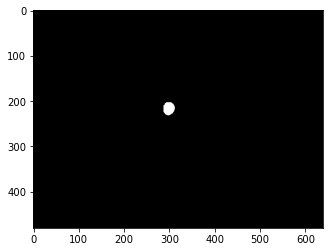

In [185]:
#A)
img=images[0][4]
#threshold = np.zeros(img.shape[:2], dtype=np.uint8) # Placeholder - replace when solving the exercise
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
n,thresh1 = cv.threshold(gray,50,255,cv.THRESH_BINARY)

#B)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
opening = cv.morphologyEx(thresh1, cv.MORPH_OPEN, kernel)
inv_img = cv.bitwise_not(opening)

plt.imshow(inv_img, cmap='gray')

In [186]:
#C) Pupil classification
contours, _= cv.findContours(inv_img, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

def contour_ratio(img):
    contours, _= cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        # find largest area contour
    max_area = -1
    cnt=[]
    for i in range(len(contours)):
        area = cv.contourArea(contours[i])
        if area>max_area:
            cnt = contours[i]
            max_area = area
    
    return  cnt


In [187]:
def find_pupil_basic(img, threshold=50,plot=False):
    """Detects and returns a single pupil candidate for a given image.

    Returns: A pupil candidate (EllipseModel) and its contour points.
    """
    # Write your implementation here.
    model = EllipseModel()
    grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    (t,thresh) = cv.threshold(grayscale,threshold,255,cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
    morph_img = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    inv_img = cv.bitwise_not(morph_img)
    contour = np.squeeze(contour_ratio(inv_img))
    
    model.estimate(contour.astype(np.float64))
    return model, contour

m,c = find_pupil_basic(img)
print(m)

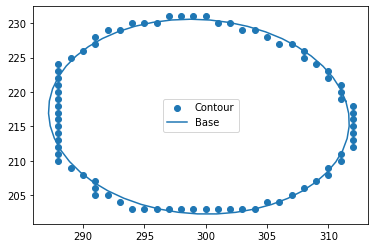

In [188]:
def plot_features(points, model_base=None, model_ransac=None):
    """This is a helper function for visualising the approximated pupil ellipses and original contour points.
    If you just want to show a single model, simply leave the other model to the default (None)
    """
    ax = plt.gca()
    points = points.astype(np.float64)

    plt.scatter(*points.T, label='Contour')
    if model_base is not None:
        plt.plot(*model_base.predict_xy(np.linspace(0, 2*np.pi)).T, label='Base')
    if model_ransac is not None:
        plt.plot(*model_ransac.predict_xy(np.linspace(0, 2*np.pi)).T, label='RANSAC')
    plt.legend()
    plt.show()
m,c=find_pupil_basic(img)
plot_features(c, m, model_ransac=None)

(ellipse:approx)=
## <i class="fas fa-exclamation-circle mandatory"></i> Ellipse approximation
The next step is to approximate the pupil with an ellipse. An ellipse can be described by the following quadratic function

$$
ax^2 + by^2 + cxy + dx + ey + f = 0,
$$

where a-f are the parameters. This function is linear in the parameters but it describes a conic section which does not need to be elliptical. The solutions are only elliptical when $b^2-4ac < 0$. This means that it is not possible to solve the equation using the simple least squares method. The solution involves the use of concepts from calculus which are outside the scope of this course. Therefore, we instead use a premade ellipse fitting model `EllipseModel` from the `scikit-image` python package.

Make the following changes to the `find_pupil_basic` function:

**A): <i class="fas fa-code"></i>** **Create the model and estimate parameters:** Read the documentation for [EllipseModel](https://scikit-image.org/docs/0.9.x/api/skimage.measure.html#skimage.measure.EllipseModel). Then:
- Instantiate an `EllipseModel` object.
- Use the `.estimate` method to estimate the parameters for your chosen contour candidate.
**B): <i class="fas fa-code"></i>** **Return the model parameters:** Return the `.params` field which contains a list of the ellipse parameters.

(test:improve)=
## <i class="fas fa-exclamation-circle mandatory"></i> Test and evaluation
Below we provide code for detecting the pupil in each image in every dataset and for constructing training and testing datasets. You have to re-add the evaluation code from last weeks exercise. 

**A): <i class="fas fa-code"></i>** **Copy evaluation code:** Copy your evaluation code for calculating the *root mean squared error* from part 1. We recommend you set up a function that returns the *rmse* for a specific dataset. This will make the general evaluation easier.

**B): <i class="fas fa-code"></i>** **Create barplot of rmse:** Visualise the *rmse* for each dataset by using a barplot.

**C): <i class="fas fa-code"></i>** **Write code for showing samples of detected pupil ellipses:** Implement a function for showing samples of detected pupils shown in the source images. The result should be similar to the visualisation from part 1 of the exercise (although it doesn't need to print every image).

**D): <i class="fas fa-code"></i>** **Evaluate:** Answer the following questions:
- How well does the pupil detector work? Does it work equally well for all datasets and images?
- Identify situations where the detector is less precise and describe their characteristics. 
- Make at least one improvement to the detector (or an attempt) and discuss the difference.
- How do the gaze results compare to the pupil results? Describe the reason for any discrepancies.

Ellipse approximation solution

In [189]:
find_pupil_basic(img)[1].shape

(77, 2)

In [190]:
# Base data
positions_train = [df.iloc[:9] for df in positions]
positions_test = [df.iloc[9:] for df in positions]
images_train = [li[:9] for li in images]
images_test = [li[9:] for li in images]

# Uncomment the following lines when your find_pupil_basic function is working

# Find pupils and construct dataframes
pupils_basic_ = [[find_pupil_basic(ii)[0].params for ii in images_row] for images_row in images]
pupils_basic = [pd.DataFrame(p, columns=['cx', 'cy', 'ax', 'ay', 'angle']) for p in pupils_basic_]
# Create train and test splits
pupils_basic_train = [df.iloc[:9] for df in pupils_basic]
pupils_basic_test = [df.iloc[9:] for df in pupils_basic]


Code from last week for gaze prediction

In [191]:
def get_pupils_train(idx):
    pupils= np.array(pupils_basic_train[idx][['cx','cy']])
    return pupils

def get_positions_train(idx):
    position= np.array(positions_train[idx][['x','y']])
    return position

def get_pupils_test(idx):
    pupils = np.array(pupils_basic_test[idx][['cx','cy']])
    return pupils

def get_positions_test(idx):
    position_test= np.array(positions_test[idx][['x','y']])
    return position_test

def get_design_matrix_q(idx):
    order=1
    count = get_pupils_train(idx).shape[0]
    matrix = np.ones((count, order + 1), np.float64)
    cy = get_pupils_train(idx)[:,1]
    for i in range(1, order+1):
        matrix[:, i] = np.power(cy, i)


    cx = get_pupils_train(idx)[:,0]
    design_matrix = np.column_stack((matrix, cx))
    design_matri = np.column_stack((design_matrix, cx*cy))
    design_matr = np.column_stack((design_matri,cy**2))
    design_mat = np.column_stack((design_matr,cx**2))
    return design_mat


def quadratic_function(pupil,params):
    f,e,d,c,b,a = params
    cx,cy = pupil
    result = a*(cx**2)+b*(cy**2)+c*(cx*cy)+d*cx+e*cy+f
    return result

def quadratic_model_X(idx):
    A = get_design_matrix_q(idx)
    y=  get_positions_train(idx)[:,0]
    params = np.linalg.lstsq(A, y, rcond=None)[0]
    return params

#Get the parameters for y′=dx+ey+f using the Y coordinate of gaze pozition as a my y at the equation below.
def quadratic_model_Y(idx):
    A = get_design_matrix_q(idx)
    y=  get_positions_train(idx)[:,1]
    paramss = np.linalg.lstsq(A, y, rcond=None)[0]
    return paramss

def gaze_prediction_q(pupils_test, idx):
    datax=[]
    for i in pupils_test:
        params_x = quadratic_model_X(idx)
        x= quadratic_function(i,params_x)

        params_y = quadratic_model_Y(idx)
        y= quadratic_function(i,params_y)
        a = [x,y]
        datax.append(a)
    return datax

Test and evaluation

Dataset 'pattern0'
__________________________________________________________
Mean squarred error:  107.5421804209926
Dataset 'pattern1'
__________________________________________________________
Mean squarred error:  68.41447638788104
Dataset 'pattern2'
__________________________________________________________
Mean squarred error:  56.079230372661314
Dataset 'moving_medium'
__________________________________________________________
Mean squarred error:  8600.748576957121
Dataset 'moving_hard'
__________________________________________________________
Mean squarred error:  4647.413821402435


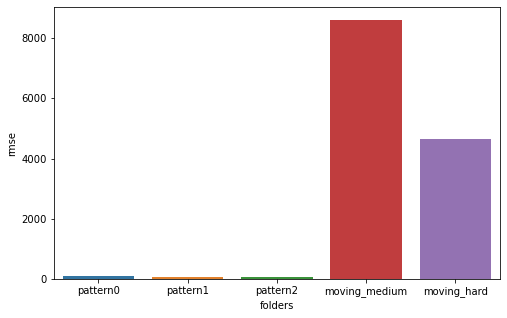

In [192]:
#A): Copy evaluation code
def rmse(x,y,idx):
    h= gaze_prediction_q(x, idx)
    mse= mean_squared_error(h,y)
    return np.sqrt(mse)

#B): Create barplot of rmse
def gaze_error():
    r_mean = np.zeros(len(pupils_basic_test))
    for i in range(len(pupils_basic_test)):
        print(f"Dataset '{dataset_folders[i]}'\n__________________________________________________________")
        r = rmse(get_pupils_test(i),get_positions_test(i),i)
        r_mean[i] = r
        print("Mean squarred error: ", r)

    quads = np.zeros(len(pupils_basic_test))
    mean_errors = pd.DataFrame({'rmse': r_mean, 'folders': dataset_folders, 'quad': quads})
    plt.figure(figsize=(8,5))
    sns.barplot(x="folders", y="rmse", data=mean_errors)

#r=rmse(get_pupils_test(0),get_positions_test(0),0)
gaze_error()

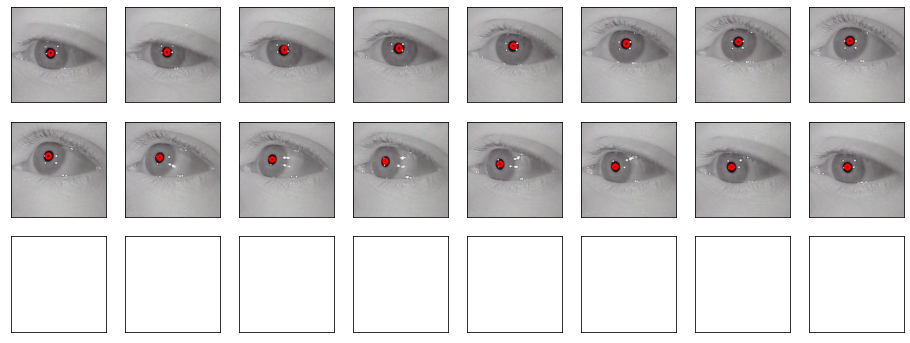

In [193]:
#C): Write code for showing samples of detected pupil ellipses
#Implement a function for showing samples of detected pupils shown in the source images. The result should be similar to the visualisation from part 1 of the exercise (although it doesn't need to print every image).
def show_example_features(images, pupils):
    """Draw a grid of images with the predicted pupils drawn on top."""
    n = len(images)
    cols = 8
    rows = n//8+1

    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, d in enumerate(images):
        img = d.copy()
        row = pupils.iloc[i]
        img = cv.ellipse(img, (int(row['cx']), int(row['cy'])), (int(row['ax']/2), int(row['ay']/2)), row['angle'], 0, 360, (255, 0, 0), 5)
        ax[i//cols, i%cols].imshow(center_crop(img, (250, 250)))
    for row in ax:
        for a in row:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
    plt.show()
show_example_features(images_test[1], pupils_basic_test[1])



D): Evaluate: Answer the following questions:
How well does the pupil detector work? Does it work equally well for all datasets and images?

Answer: It works well for all the datasets

Identify situations where the detector is less precise and describe their characteristics.

Answer: I identifyed some missing data images without pupil prediction.

Make at least one improvement to the detector (or an attempt) and discuss the difference.
Answer:I tried to apply different morphology but couldn't find better results

How do the gaze results compare to the pupil results? Describe the reason for any discrepancies.

Answer:Although the pupil results are good, can't say the same for the gaze results specially for head moviment dataset which rmse is very high.
The fact that the gaze results are not as good has nothing to do with the pupil detection itself but the quality of training data that we choose to train the gaze model. 
In case of head moviment data the gaze position a rather circular so its hard to fit the data into our model so we see higher error in those datasets.

(ransac)=
## <i class="fas fa-exclamation-circle mandatory"></i> RANSAC
You now have a base implementation for detecting pupils. However, like with regular regression, the approximation method is sensitive to outliers. In this case, outliers may be spurious points caused by noise in the thresholding phase. Using RANSAC might improve the detection accuracy slightly by ignorring these outliers.

You have to implement the function `ransac`. The function `find_pupil_ransac` should use the same method as the `find_pupil_basic` function with the exceptation that ellipse approximation is delegated to the `ransac` function. You are welcome to combine the pupil detection functions if you think that approach is easier.

**A): <i class="fas fa-code"></i>** **Implement RANSAC:** Use information from the course to implement the RANSAC algorithm. We provide a few hints:
- You need to select a subset of `points`. The existing parameters suggest that each subset should consist of `len(points)*frac` points. You can use the following Numpy code to select a subset:
    ```
    subset_idx = np.random.choice(len(points), int(len(points)*frac), replace=False)
    subset = points[subset_idx]
    ```
- Create a new `EllipseModel` for each iteration and estimate parameters like you did previously.
- Use the `.residuals` method of the ellipse model to calculate the error of each contour point in `points`.
- Count the number of points with an error less than `distance`.
- Keep track of the best model, i.e. the one with most *inliers* (points below the error distance threshold).
**B): <i class="fas fa-code"></i>** **Finish `find_pupil_ransac`:** Complete the function and return the model parameters (a list of five values).

**C): <i class="fas fa-code"></i>** **Questions:** Answer the following:
- Make a qualitative assessment of how the RANSAC approach compares to the simple approach. If you find a striking example, please discuss it.

In [194]:
def ransac(points, frac=0.6, distance=0.5, iters=50):
    
    iterations_done = 0
    count_error = 0
    point=[]     
    minimum_error = sys.maxsize
    best_point = []
    model1= None
    #point = np.squeeze(points)
    while iters > iterations_done:
        subset_idx = np.random.choice(len(points), int(len(points)*frac), replace=False)
        subset = points[subset_idx]
        model = EllipseModel()
        model.estimate(subset.astype(np.float64))
        error = model.residuals(subset)
        for i in error:
            if (i<distance):
                count_error+=1
        if(count_error<minimum_error):
            best_point = subset
            model1=model
            minimum_error = count_error
        iterations_done+=1
        count_error=0
       
    return model1

def find_pupil_ransac(imge, threshold=50):
    """Detects and returns a single pupil candidate for a given image.

    Returns: A pupil candidate in OpenCV ellipse format.
    """
    # Write your implementation here.
    grayscale = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    (t,thresh) = cv.threshold(grayscale,threshold,255,cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
    morph_img = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)
    inv_img = cv.bitwise_not(morph_img)
    contour = np.squeeze(contour_ratio(inv_img))
    model= ransac(contour)
    
    return model, contour

(evaluation:two)=
## <i class="fas fa-exclamation-circle mandatory"></i> Evaluation

You now have to evaluate and compare the RANSAC and basic approach to pupil detection. We have included some code to generate pupil features using the RANSAC method for all datasets. The code is in the cell below this one. Just like for the basic version, we have created a training and test dataset for you to use in the gaze model.

**A): <i class="fas fa-code"></i>** **Calculate errors for RANSAC:** Calculate the *rmse* for each individual dataset when using the RANSAC ellipse approximation method. Calculate the errors for at least two different sets of parameters for the `ransac` function.

**B): <i class="fas fa-code"></i>** **Compare performance:** Visualise the errors of all approaches in the same plot and answer the following:
- Does the RANSAC model improve performance and if yes, how significantly?
- Explain any difference between the two RANSAC models. You should be able to explain how the parameters have impacted the outcome.

**C): <i class="fas fa-code"></i>** **Reflecting on the gaze error:** You will likely find that, even with RANSAC, the gaze error is still relatively high for the first three datasets and extremely high for the last two datasets. Answer the following:
- What is the reason for this? You should be able to relate this to the concept of bias from the course. Consider the following thought experiment: What if the pupil detection method was perfect - what would the gaze error be? *Hint: The two datasets where the head is freely moving should reveal what our current model does not account for*.

In [195]:
# Uncomment the following lines when your find_pupil_basic function is working


pupils_ransac_ = [[find_pupil_ransac(ii)[0].params for ii in images_row] for images_row in images]
pupils_ransac = [pd.DataFrame(p, columns=['cx', 'cy', 'ax', 'ay', 'angle']) for p in pupils_ransac_]

pupils_ransac_train = [df.iloc[:9] for df in pupils_ransac]
pupils_ransac_test = [df.iloc[9:] for df in pupils_ransac]

#find_pupil_ransac(img)
#print(pupils_ransac_test)

In [196]:
def get_pupils_train_ransac(idx):
    pupils= np.array(pupils_ransac_train[idx][['cx','cy']])
    return pupils



def get_pupils_test_ransac(idx):
    pupils = np.array(pupils_ransac_test[idx][['cx','cy']])
    return pupils


def get_design_matrix_rasac(idx):
    order=1
    count = get_pupils_train_ransac(idx).shape[0]
    matrix = np.ones((count, order + 1), np.float64)
    cy = get_pupils_train_ransac(idx)[:,1]
    for i in range(1, order+1):
        matrix[:, i] = np.power(cy, i)


    cx = get_pupils_train_ransac(idx)[:,0]
    design_matrix = np.column_stack((matrix, cx))
    design_matri = np.column_stack((design_matrix, cx*cy))
    design_matr = np.column_stack((design_matri,cy**2))
    design_mat = np.column_stack((design_matr,cx**2))
    return design_mat


def quadratic_model_X_rasac(idx):
    A = get_design_matrix_rasac(idx)
    y=  get_positions_train(idx)[:,0]
    params = np.linalg.lstsq(A, y, rcond=None)[0]
    return params

#Get the parameters for y′=dx+ey+f using the Y coordinate of gaze pozition as a my y at the equation below.
def quadratic_model_Y_rasac(idx):
    A = get_design_matrix_rasac(idx)
    y=  get_positions_train(idx)[:,1]
    paramss = np.linalg.lstsq(A, y, rcond=None)[0]
    return paramss

def gaze_prediction_q_rasac(pupils_test, idx):
    datax=[]
    for i in pupils_test:
        params_x = quadratic_model_X_rasac(idx)
        x= quadratic_function(i,params_x)

        params_y = quadratic_model_Y_rasac(idx)
        y= quadratic_function(i,params_y)
        a = [x,y]
        datax.append(a)
    return datax


Dataset 'pattern0'
__________________________________________________________
Mean squarred error:  3259.244567639252
Distance error:  27655.60722387759
Dataset 'pattern1'
__________________________________________________________
Mean squarred error:  573.1831497030136
Distance error:  3242.413536134919
Dataset 'pattern2'
__________________________________________________________
Mean squarred error:  3318.1012332828827
Distance error:  23462.518827177726
Dataset 'moving_medium'
__________________________________________________________
Mean squarred error:  1216.4761421601113
Distance error:  10322.142351276787
Dataset 'moving_hard'
__________________________________________________________
Mean squarred error:  1218.9069856766064
Distance error:  10342.76874249099


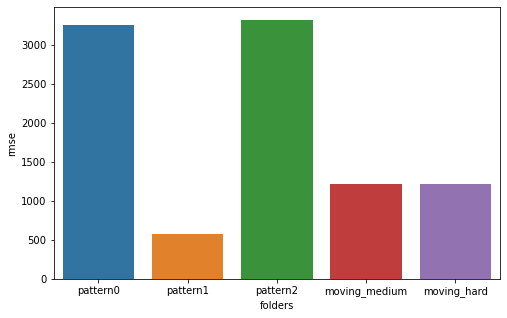

In [197]:
def rmse_rasac(x,y,idx):
    h= gaze_prediction_q_rasac(x, idx)
    mse= mean_squared_error(h,y)
    return np.sqrt(mse)
    

#B): Create barplot of rmse
def gaze_error_ransac():
    r_mean = np.zeros(len(pupils_basic_test))
    dis = np.zeros(len(pupils_basic_test))
    for i in range(len(pupils_basic_test)):
        prediction= gaze_prediction_q_rasac(get_pupils_test_ransac(i), i)
        print(f"Dataset '{dataset_folders[i]}'\n__________________________________________________________")
        r = rmse_rasac(get_pupils_test_ransac(i),get_positions_test(i),i)
        r_mean[i] = r
        euclidean_dist = np.linalg.norm(get_positions_test(i)-prediction)
        dis[i] = euclidean_dist
        print("Mean squarred error: ", r)
        print("Distance error: ", euclidean_dist)
    quads = np.zeros(len(pupils_basic_test))
    mean_errors = pd.DataFrame({'rmse': r_mean, 'folders': dataset_folders, 'quad': quads})
    plt.figure(figsize=(8,5))
    sns.barplot(x="folders", y="rmse", data=mean_errors)



gaze_error_ransac()

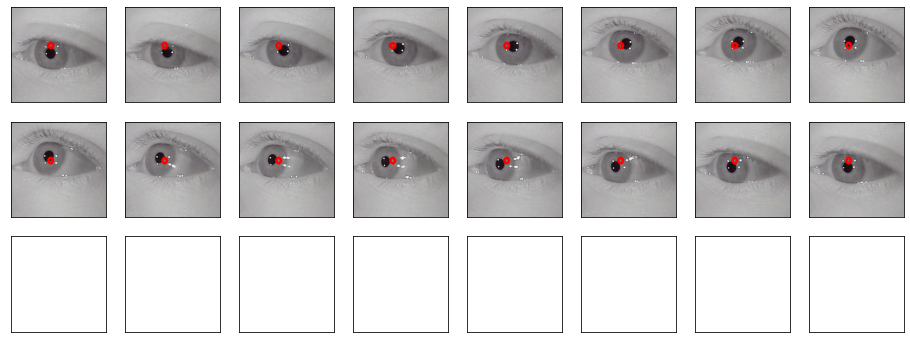

In [198]:
show_example_features(images_test[1], pupils_ransac_test[1])


Does the RANSAC model improve performance and if yes, how significantly?
 Answer:The performance has not improved the rmse graph above shows how the model fit the test data, by comparing the versions, the ransac rms shows that the the rmse is higher so it tells as that the first approach was better.

Explain any difference between the two RANSAC models. You should be able to explain how the parameters have impacted the outcome.
Answer:With Ransac model I expeted it to be more precise than the fist model however is not what I vizualized. The all idea of ransac is that we train the model by removing outliers and get the respective parameters in hope to have a more precise model, but I believe that by using the ransac model in this case, the model is overfitting which mean that might not work as wished in the testing fase.

Reflecting on the gaze error: You will likely find that, even with RANSAC, the gaze error is still relatively high for the first three datasets and extremely high for the last two datasets. Answer the following:

What is the reason for this? You should be able to relate this to the concept of bias from the course. Consider the following thought experiment: What if the pupil detection method was perfect - what would the gaze error be? Hint: The two datasets where the head is freely moving should reveal what our current model does not account for.

Answer: The pupil detection precision has nothing to do with how well the gaze error be, the problem is that we train the gaze model with dataset that are not head moviment so our training is bias because we do not count how the model would behave in case of runnning head moviment data set for testing.